# Constant Acceleration and Noise

Generate 2d kinematic data with constant acceleration and noise. Adds noise to each measurement

In [98]:
using Plots
using TimerOutputs

function generateKinematics(ax,ay,x0,y0,vx0,vy0,dt,measurements,noise,vnoise)
    #Measurement Arrays
    x = [x0]
    y = [y0]
    vx = [vx0]
    vy = [vy0]

    #Generate true gold set data based on kinematic equations 
    for i in 2:measurements
        if i == 50
            ax *= 10
        end
        xi = x[i-1] + vx[i-1] * dt + ax * .5 * dt^2
        yi = y[i-1] + vy[i-1] * dt + ay * .5 * dt^2
        vxi = vx[i-1] + ax*dt
        vyi = vy[i-1] + ay*dt
        append!(x,xi)
        append!(y,yi)
        append!(vx,vxi)
        append!(vy,vyi)
    end

    #Plot true data
    #plot(x,y, label="True")

    #Add and plot noise
    xn = x + (rand(Float64,size(x)) .* noise .- noise/2)
    yn = y + (rand(Float64,size(y)) .* noise .- noise/2)
    vxn = vx + (rand(Float64,size(vx)) .* vnoise .- vnoise/2)
    vyn = vy + (rand(Float64,size(vy)) .* vnoise .- vnoise/2)
    measurements = hcat(xn,yn,vxn,vyn)
    measurementsTrue = hcat(x,y,vx,vy)
    #scatter!(xn,yn,label="Measured")
    return measurements, measurementsTrue
end

noise = 30
vnoise = 2
dt = 1
measurements = 100
#ax,ay,x,y,vx,vy
m1,m1T = generateKinematics( .1 , .1  ,0.0   ,60.0  ,0.0, 0.0,dt,measurements,noise,vnoise)
m2,m2T = generateKinematics(-.1 , .1  ,400.0 ,400.0,0.0, 0.0,dt,measurements,noise,vnoise)
m3,m3T = generateKinematics( 0.05, 0.05 ,20.0  ,30.0 ,0.0, 0.0,dt,measurements,noise,vnoise)
m4,m4T = generateKinematics(  0 , .1  ,333   ,0.0  ,0.0, 0.0,dt,measurements,noise,vnoise)
measurementsNoise = permutedims(cat(m1,m2,m3,m4,dims=3),[2,3,1])
measurementsTrue = permutedims(cat(m1T,m2T,m3T,m4T,dims=3),[2,3,1])

4×4×100 Array{Float64,3}:
[:, :, 1] =
  0.0  400.0  20.0  333.0
 60.0  400.0  30.0    0.0
  0.0    0.0   0.0    0.0
  0.0    0.0   0.0    0.0

[:, :, 2] =
  0.05  399.95  20.025  333.0 
 60.05  400.05  30.025    0.05
  0.1    -0.1    0.05     0.0 
  0.1     0.1    0.05     0.1 

[:, :, 3] =
  0.2  399.8  20.1  333.0
 60.2  400.2  30.1    0.2
  0.2   -0.2   0.1    0.0
  0.2    0.2   0.1    0.2

...

[:, :, 98] =
 1550.9   -1150.9   795.45   333.0 
  530.45    870.45  265.225  470.45
   53.8     -53.8    26.9      0.0 
    9.7       9.7     4.85     9.7 

[:, :, 99] =
 1605.2  -1205.2  822.6  333.0
  540.2    880.2  270.1  480.2
   54.8    -54.8   27.4    0.0
    9.8      9.8    4.9    9.8

[:, :, 100] =
 1660.5   -1260.5   850.25   333.0 
  550.05    890.05  275.025  490.05
   55.8     -55.8    27.9      0.0 
    9.9       9.9     4.95     9.9 

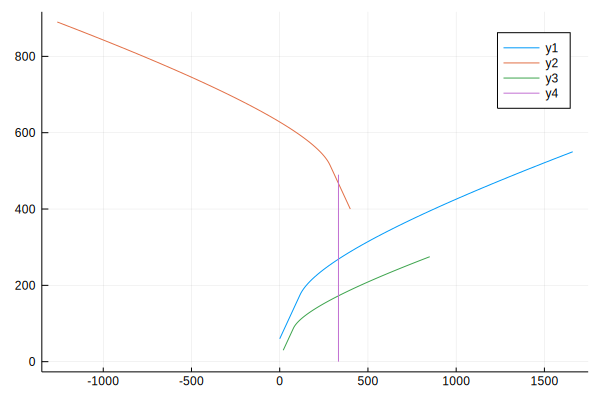

In [99]:
plot(measurementsTrue[1,1,:],measurementsTrue[2,1,:])
plot!(measurementsTrue[1,2,:],measurementsTrue[2,2,:])
plot!(measurementsTrue[1,3,:],measurementsTrue[2,3,:])
plot!(measurementsTrue[1,4,:],measurementsTrue[2,4,:])

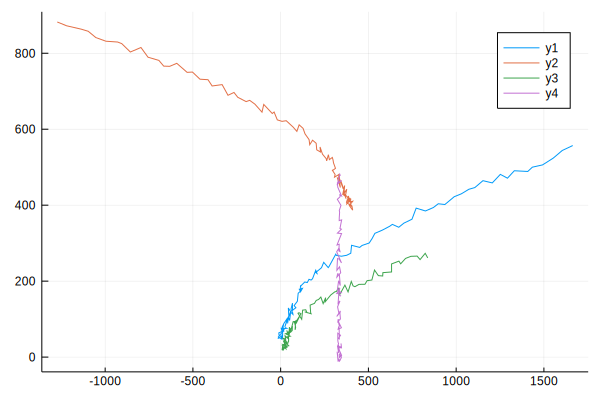

In [100]:
plot(measurementsNoise[1,1,:],measurementsNoise[2,1,:])
plot!(measurementsNoise[1,2,:],measurementsNoise[2,2,:])
plot!(measurementsNoise[1,3,:],measurementsNoise[2,3,:])
plot!(measurementsNoise[1,4,:],measurementsNoise[2,4,:])

In [101]:
file = open("data/measurements.hpp","w+")
print(size(measurementsNoise))
write(file, "float measurements[100][16] = {")
write(file, replace(replace(replace(replace(string(permutedims(measurementsNoise,(2,1,3))) , "[" => "{"),"]"=>"},")," "=>", "),";,"=>",")[1:end-1])  
write(file, "};\n")

close(file)

(4, 4, 100)

Kalman Filter Functions

In [102]:
using LinearAlgebra
function predict(A,X,B,U,P,Q)
    Xp = A*X + B.*U
    Pp = A *P*transpose(A) + Q
    return Xp,Pp
end

function update(P,H,R,Xp,Y)
    Ht = transpose(H)
    K= (P*Ht) * inv(H*P*Ht+R)
    Xk = Xp + K* (Y-H*Xp)
    Pk = (I - K*H)*P
    return Xk,Pk,K
end 

update (generic function with 1 method)

In [103]:
innovationCollection = []
function adapt(K,H,Y,Xk,Pk,Q,R)
    pushfirst!(innovationCollection, Y .- Xk)
    Cv = zeros(size(Y))
    if size(innovationCollection)[1] == 20
        for i in 1:20
           Cv .+= (innovationCollection[i] * transpose(innovationCollection[i]))
        end
        Cv ./= 20
        #R = Cv - H * Pk * transpose(H)
        Q = (K * Cv * transpose(K))
        pop!(innovationCollection)
    end
    return Q,R
end
#=
i = 0
test = []
counts = zeros(4,4)
function adapt1(K,H,Y,Xk,Pk,Q,R)
    if i > 5
        res = Xk .- Y
        eps = transpose(res) * inv(Pk) * res
        eps = abs.(eps)
        eps = (eps .> 100)
        counts .+= eps
        subtraction = (counts .!= 0) .& (eps .== 0)
        counts .-= subtraction
        
        eps = (eps .* 99) .+ 1
        subtraction = (subtraction .* 99) .+ 1
        #display(eps)
        Q = Q .* eps
        Q = Q ./ subtraction
        
        push!(test,eps)
        #println(string(i) * " " * string(sum(eps)))
    end
    #display(Q)
    global i
    i += 1
    return Q,R
end =#

test = []

function generateResiduals(Y,Xk,Pk,R)
    res = Xk .- Y
    eps = transpose(res) * inv(Pk+R) * res
    eps = abs.(eps)
    push!(test,eps)
end

generateResiduals (generic function with 1 method)

Runs the Kalman Filter on kinematic data. State transition models based off kinematic equations. 
Non diagonal Covariance terms not used for simplicity.

In [104]:
function runKalmanKinematic(measurements,dt,ax1,ay1,ax2,ay2,ax3,ay3,ax4,ay4,noise,vnoise)
    #Set up initial state
    X = measurements[:,:,1]
    xpred = [X]
    kalmanGains = []
    
    #State transisition matrix, adds dt*velocity to position
    A = [1 0 dt 0; 0 1 0 dt; 0 0 1 0; 0 0 0 1]
    
    #Control matrix, updates position and velocity based on acceleration
    B = [.5*dt^2;.5*dt^2;dt;dt] 
    U = [ax1 ax2 ax3 ax4;ay1 ay2 ay3 ay4;ax1 ax2 ax3 ax4;ay1 ay2 ay3 ay4]
    H = I
    R = [noise^2 0 0 0;
         0 noise^2 0 0;
         0 0 vnoise^2 0;
         0 0 0 vnoise^2]
    Q= [1 0 0 0; 0 1 0 0; 0 0 1 0; 0 0 0 1]
    #Q = I 
    P = Q
    Kprev = []
    to = TimerOutput()
    @timeit to "For" begin
        for i in 2:(size(measurements)[3])
            Xp, Pp = predict(A,X,B,U,P,Q)
            Q,R = adapt(Kprev,H,measurements[:,:,i],Xp,Pp,Q,R)
            generateResiduals(measurements[:,:,i],Xp,Pp,R)
            Xk, Pk, Kprev = update(Pp,H,R,Xp,measurements[:,:,i])
            append!(xpred,[Xk])
            append!(kalmanGains,[diag(Kprev)])
            P = Pk
            X = Xk
        end
    end
    show(to; allocations = false)

    #display(X)
    return cat(xpred...,dims=3),hcat(kalmanGains...)
end

runKalmanKinematic (generic function with 1 method)

Kalman Filter is run on measurements, green line is filtered value and blue line is the true value

 ────────────────────────────────────────
                           Time          
                   ──────────────────────
 Tot / % measured:      515ms / 100%     

 Section   ncalls     time   %tot     avg
 ────────────────────────────────────────
 For            1    515ms   100%   515ms
 ────────────────────────────────────────

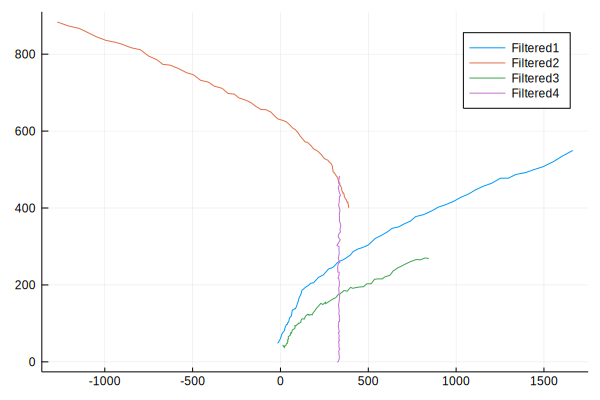

In [105]:
xf,kGains = runKalmanKinematic(measurementsNoise,dt,.1,.1,-.1,.1,0.05,0.05,0,.1,noise/2,vnoise/2)
plot(xf[1,1,:],xf[2,1,:],label="Filtered1")
plot!(xf[1,2,:],xf[2,2,:],label="Filtered2")
plot!(xf[1,3,:],xf[2,3,:],label="Filtered3")
plot!(xf[1,4,:],xf[2,4,:],label="Filtered4")

RMSE error of filtered values. X, Y, Vx, Vy in order

In [106]:
sqrt.(sum((xf - (measurementsTrue)).^2,dims=3)/100)

4×4×1 Array{Float64,3}:
[:, :, 1] =
 11.1148    10.1742    6.09744   3.62115 
  5.34451    3.20882   5.20888   2.69708 
  0.65527    0.714691  0.489172  0.373116
  0.295021   0.291715  0.253611  0.279493

In [107]:
measurementsTrue[:,:,100] - xf[:,:,100]

4×4 Array{Float64,2}:
 -3.34445   10.0116    5.69349   -3.90517  
  0.494794   6.43354   6.07519    6.62541  
 -0.234912   0.525247  0.89386    0.0900962
 -0.24984    0.234669  0.170812   0.283946 

3.24677      1.05831     -2.251      -9.97928  
 -1.1081       5.56782     -8.82951    -0.938429 
  0.00817151  -0.00394319  -0.0964537  -0.413184 
 -0.0332296    0.160126    -0.248645   -0.0350788


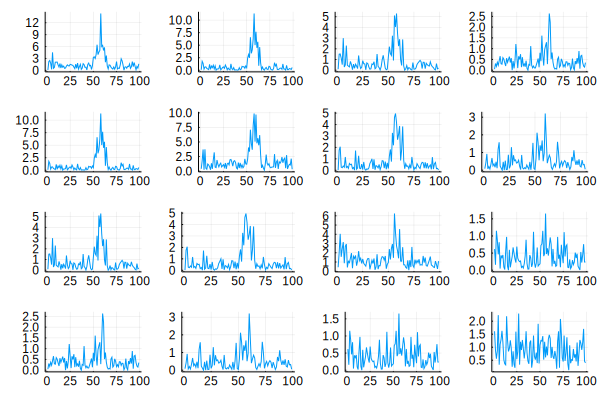

In [108]:
plots = []
for i in 1:4
    for j in 1:4
        #subplots(i,j,i*4 + j)
        push!(plots,plot(abs.(cat(test...,dims=3)[i,j,:])))
    end
end
plot(plots...,legend=false)

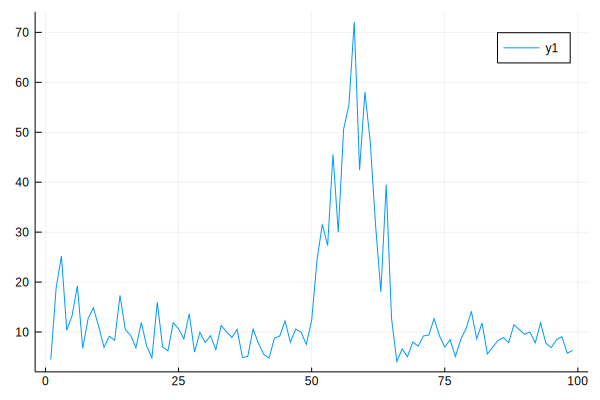

In [109]:
plot(sum(abs.(cat(test...,dims=3)),dims=[1,2])[:])